# Summary
If a bottle is shaped like a **cone**,  
then, if it is filled with a **constant volume flow rate**,  
it produces a *sound* that is **very similar**  
in its **frequency evolution** (i.e. "chirp")  
to that of the **gravitational waves**  
produced by an **inspiraling equal mass binary** of some mass  
that coalesces when the bottle is fully filled.

Suggested specifications according to the simulation:
* Bottle height: 33 cm
* Base radius: 5 cm
* Opening radius: 1 cm
* Shape: conical
* Volume: 1.07 liters
* Required flow rate: 107 ml per second
* Sound duration: 10 seconds
* Best fit chirp mass: 0.0539 Msun
* Best fit equal mass: 0.0619 Msun

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, cumulative_trapezoid
from tqdm import tqdm

In [2]:
H = 0.33 # m
cs = 330 # m/s
duration = 10 # s
Rbase = 0.05 # m
Ropen = 0.01 # m

def R_z(z): return ((Rbase - Ropen) * (1 - z) + Ropen) / H # conical

All lengths in the units of $H$.

Approximate 1D wave equation (from Acoustics of a wine bottle by A. Cummings)
$$\dfrac{d^2p}{dz^2}+\dfrac{d\ln{A(z)}}{dz}\dfrac{dp}{dz}+\dfrac{\pi^2}{4}k^2p=0$$
where $z$ is in the units of height of the bottle, and $k$ is in the units of the first natural wavenumber for a cylinder ($=0.5\pi/H$).

This is to be solved between various $z_0$ to 1 with the following boundary conditions
* To ensure node at the bottom
$$p \left. \right|_{z=0} = z_0$$
* To set arbitrary amplitude (we only care about the mode frequencies)
$$\left. \dfrac{dp}{dz} \right|_{z=z_0} = 1$$

There is one more condition we need to impose to obtain natural frequencies ($k_n$),
$$\left. \dfrac{dp}{dz} \right|_{z=1} = 0$$
but in an IVP formalism, we'll just have to solve for many $k$ and see where this occurs.

Volume (Ltr): 1.0712833718880224
Required flow rate (ml/s): 107.12833718880226


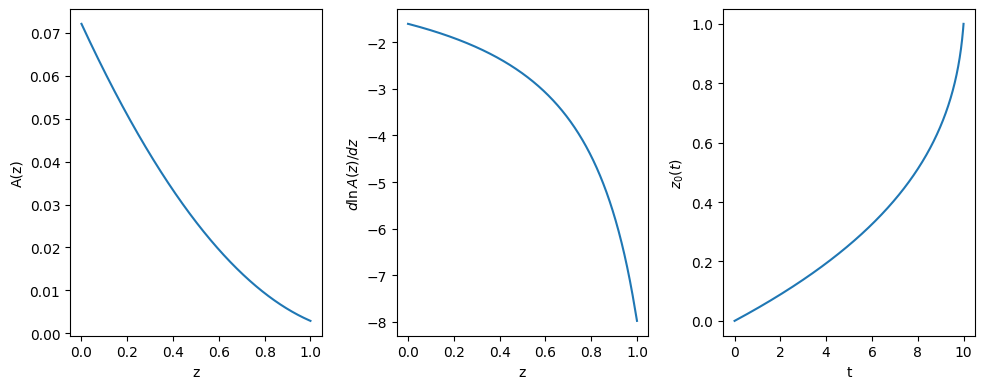

In [3]:
def A_z(z): return np.pi * R_z(z)**2.0

z_arr = np.linspace(0,1,1000)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(z_arr, A_z(z_arr))
plt.ylabel('A(z)')
plt.xlabel('z')

B_z = lambda z: np.interp(z, z_arr, np.gradient(np.log(A_z(z_arr)), z_arr))
plt.subplot(1,3,2)
plt.plot(z_arr, B_z(z_arr))
plt.ylabel(r'$d\ln{A(z)}/dz$')
plt.xlabel('z')

t = np.linspace(0,duration,300)
V_arr = cumulative_trapezoid(A_z(z_arr), z_arr, initial=0)
Q = V_arr.max() / t.max() # required flow rate in H^3/s
print('Volume (Ltr):', V_arr.max() * H**3 * 1e3)
print('Required flow rate (ml/s):', Q * H**3 * 1e6)
t_arr = V_arr / Q
z0_t = lambda t: np.interp(t, t_arr, z_arr)

plt.subplot(1,3,3)
plt.plot(t_arr, z0_t(t_arr))
plt.ylabel(r'$z_0(t)$')
plt.xlabel('t')
plt.tight_layout()
plt.show()

In [4]:
def dydz(z, y, k):
    p, q = y
    dpdz = q
    dqdz = -B_z(z) * q - 0.25 * np.pi**2.0 * k**2 * p
    return [dpdz, dqdz]

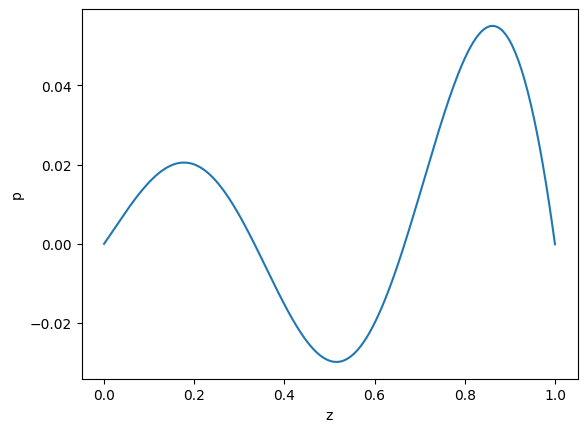

In [5]:
k = 6
z0 = 0.
z_eval = np.linspace(z0, 1, 300)
sol = solve_ivp(dydz, [z_eval.min(),z_eval.max()], [0, 1./k], t_eval=z_eval, args=(k,))
plt.plot(sol.t, sol.y[0])
plt.xlabel('z')
plt.ylabel('p')
plt.show()

In [6]:
def find_k0(z0, k0, dk=1e-6, tol=1e-6, maxiter=100):
    q = 1.
    it = 0
    z_eval = np.linspace(z0, 1, 3)
    while np.abs(q) > tol and it < maxiter:
        k = k0
        sol = solve_ivp(dydz, [z_eval.min(),z_eval.max()], [0, 1], t_eval=z_eval, args=(k,))
        q = sol.y[1][-1]
        k = k0 + dk
        sol = solve_ivp(dydz, [z_eval.min(),z_eval.max()], [0, 1], t_eval=z_eval, args=(k,))
        dq = sol.y[1][-1] - q
        k0 = k0 - q / dq * dk # essentially Newton Raphson
        it = it + 1
    return k

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 47.04it/s]


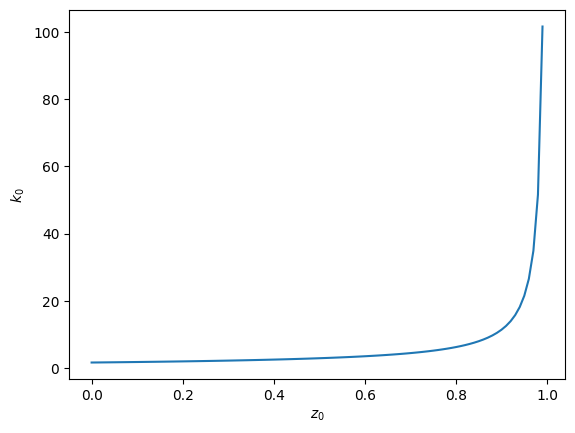

In [7]:
z0_arr = np.linspace(0, 0.99, 100)
k0_arr = z0_arr * 0 + 1.
for i in tqdm(range(len(z0_arr))):
    k0_arr[i] = find_k0(z0_arr[i], k0_arr[i-1])

plt.plot(z0_arr, k0_arr)
plt.xlabel(r'$z_0$')
plt.ylabel(r'$k_0$')
plt.show()

In [8]:
def binary_chirp(t, Mc, tc):
    return 155.7 * Mc**(-5./8.) / (tc - t)**(3.0/8.0)

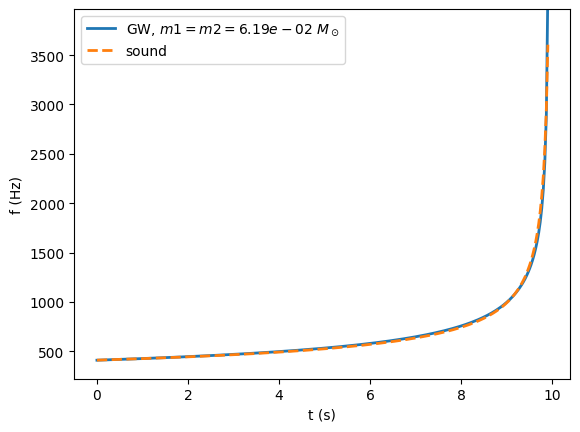

In [9]:
f0_arr = cs * k0_arr / 4. / H
tc = duration - 8e-2
gw = binary_chirp(t, 1, duration + 1e-2)
sound = np.interp(z0_t(t), z0_arr, f0_arr)
Mc = (np.mean(sound[t<4] / gw[t<4]))**(-8./5.)
sound = sound[t < tc]
t = t[t < tc]
gw = binary_chirp(t, Mc, tc)

plt.plot(t, gw, label=r'GW, $m1=m2=%.2e\ M_\odot$' % (Mc * 2**0.2), lw=2)
plt.plot(t, sound, label='sound', ls='--', lw=2)
plt.legend()
plt.xlabel('t (s)')
plt.ylabel('f (Hz)')
plt.ylim(None, 1.1 * min([max(gw), max(sound)]))
# plt.yscale('log')
plt.show()